In [137]:
import galarp as grp
grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from gala.units import galactic

from gala import potential as gp

from scipy import stats
from scipy.interpolate import interp1d

from matplotlib import animation

In [3]:
test = gp.MilkyWayPotential()
print(test.parameters)

for key in test.parameters.keys():
    print(key, test.parameters[key], test[key])


{'disk': {'m': <Quantity 6.8e+10 solMass>, 'a': <Quantity 3. kpc>, 'b': <Quantity 0.28 kpc>}, 'bulge': {'m': <Quantity 5.e+09 solMass>, 'c': <Quantity 1. kpc>}, 'nucleus': {'m': <Quantity 1.71e+09 solMass>, 'c': <Quantity 0.07 kpc>}, 'halo': {'m': <Quantity 5.4e+11 solMass>, 'r_s': <Quantity 15.62 kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>}}
disk {'m': <Quantity 6.8e+10 solMass>, 'a': <Quantity 3. kpc>, 'b': <Quantity 0.28 kpc>} MiyamotoNagaiPotential
bulge {'m': <Quantity 5.e+09 solMass>, 'c': <Quantity 1. kpc>} HernquistPotential
nucleus {'m': <Quantity 1.71e+09 solMass>, 'c': <Quantity 0.07 kpc>} HernquistPotential
halo {'m': <Quantity 5.4e+11 solMass>, 'r_s': <Quantity 15.62 kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>} NFWPotential


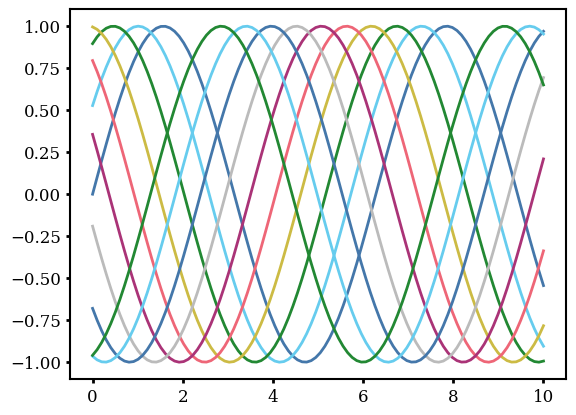

In [52]:

galarp_colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377', '#BBBBBB']

plt.figure()
for i, shift in enumerate(np.linspace(0, 5, 10)):
    plt.plot(np.linspace(0, 10, 100), np.sin(np.linspace(0, 10, 100) + shift), color=galarp_colors[i % len(galarp_colors)], lw=2)

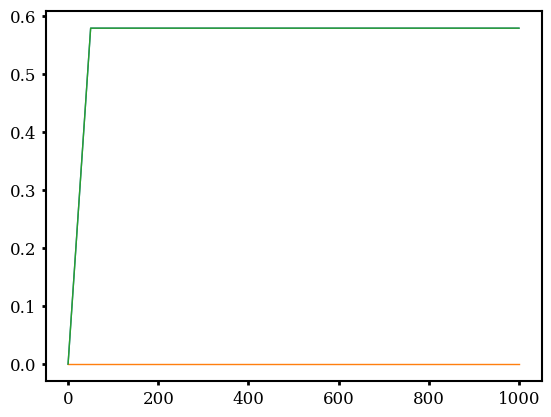

In [85]:

def RB2006_Satellite():
    """ Satellite potential for Roediger & Brüggen 2006
        See https://academic.oup.com/mnras/article/369/2/567/3101476
    """

    dm = gp.BurkertPotential.from_r0(23 * u.kpc, units=galactic)

    stars = gp.MiyamotoNagaiPotential(m=1e11 * u.Msun, a=4 * u.kpc, b=0.25 * u.kpc, units=galactic)
    bulge = gp.HernquistPotential(m=1e10 * u.Msun, c=0.4 * u.kpc, units=galactic)
    
    gas = gp.MiyamotoNagaiPotential(m=10**10 * u.Msun, a=7 * u.kpc, b=0.4 * u.kpc, units=galactic)

    return gp.CompositePotential(dm=dm, stars=stars, bulge=bulge, gas=gas)


def RB2006_Wind(inc = 45, peak = 800):
    
    peak = peak * (u.km/u.s).to(u.kpc / u.Myr)

    i_x, i_y = np.linspace(0, 50, 50), np.linspace(0, peak, 50)

    i_x = np.concatenate([i_x, np.linspace(50, 1000, 950)])
    i_y = np.concatenate([i_y, peak * np.ones(950)])

    interp = interp1d(i_x, i_y, bounds_error=False, fill_value="extrapolate")

    wind = grp.InterpolatedWind(interp=interp, inc=np.deg2rad(inc), units=galactic)

    return wind

wind = RB2006_Wind(inc=45, peak=800)

times = np.linspace(0, 1000, 1000) * u.Myr

plt.plot(times, wind.evaluate_arr(times), label="Wind")

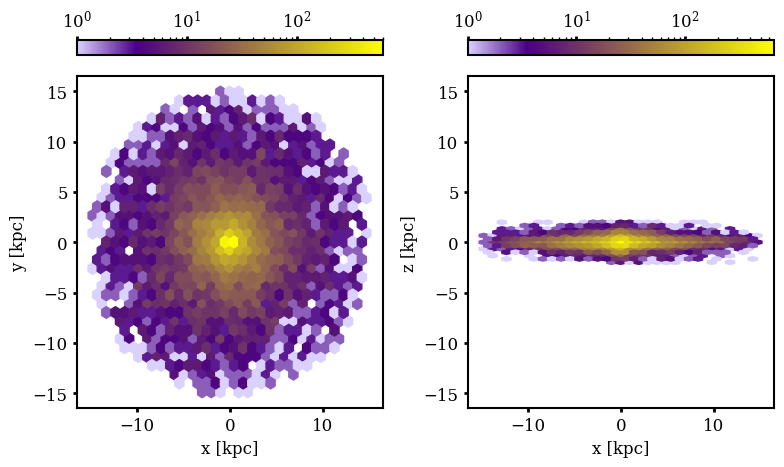

In [86]:
rb2006_satellite = RB2006_Satellite()

mass_profile = grp.gen_mass_profile(rb2006_satellite)

# positions = grp.generate_exponential_positions(10000, 
#                                                h_R = rb2006_satellite["gas"].parameters["a"], 
#                                                h_z = rb2006_satellite["gas"].parameters["b"],
#                                                outname="temp/positions_RB.npy")

particles = grp.ExponentialGrid(h_R=rb2006_satellite["gas"].parameters["a"],
                                h_z=rb2006_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions_RB.npy")

particles.plot_density(cmap=cmap, gridsize=30)

In [91]:

rb2006_wind = RB2006_Wind()
shadow = grp.UniformExponentialZVariableShadow(damping = 0.3, R_disk=rb2006_satellite["gas"].parameters["a"], dynamic=True, z_dropoff=40)

sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow, rho_icm=1e-26 * u.g/u.cm**3)
orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)




 21%|██        | 82/399 [00:02<00:08, 37.50it/s]/Users/hsouchereau/galarp/galarp/rampressure.py:44: RuntimeWarning: overflow encountered in square
  v_perp**2
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:14: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/Users/hsouchereau/galarp/galarp/shadows.py:351: RuntimeWarning: overflow encountered in square
  dist = np.sqrt((x - cent) ** 2 + y**2)
/Users/hsouchereau/gala/gala/integrate/pyintegrators/rk5.py:79: RuntimeWarning: invalid value encountered in multiply
  dw = dw + C[i]*K[i]
100%|██████████| 399/399 [00:09<00:00, 40.27it/s]


/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5001: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(iy).astype(int)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5003: RuntimeWarning: invalid value encountered in cast
  iy2 = np.floor(iy).astype(int)
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:28: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5010: RuntimeWarning: overflow encountered in square
  d1 = (ix - ix1) ** 2 + 3.0 * (iy - iy1) ** 2
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.

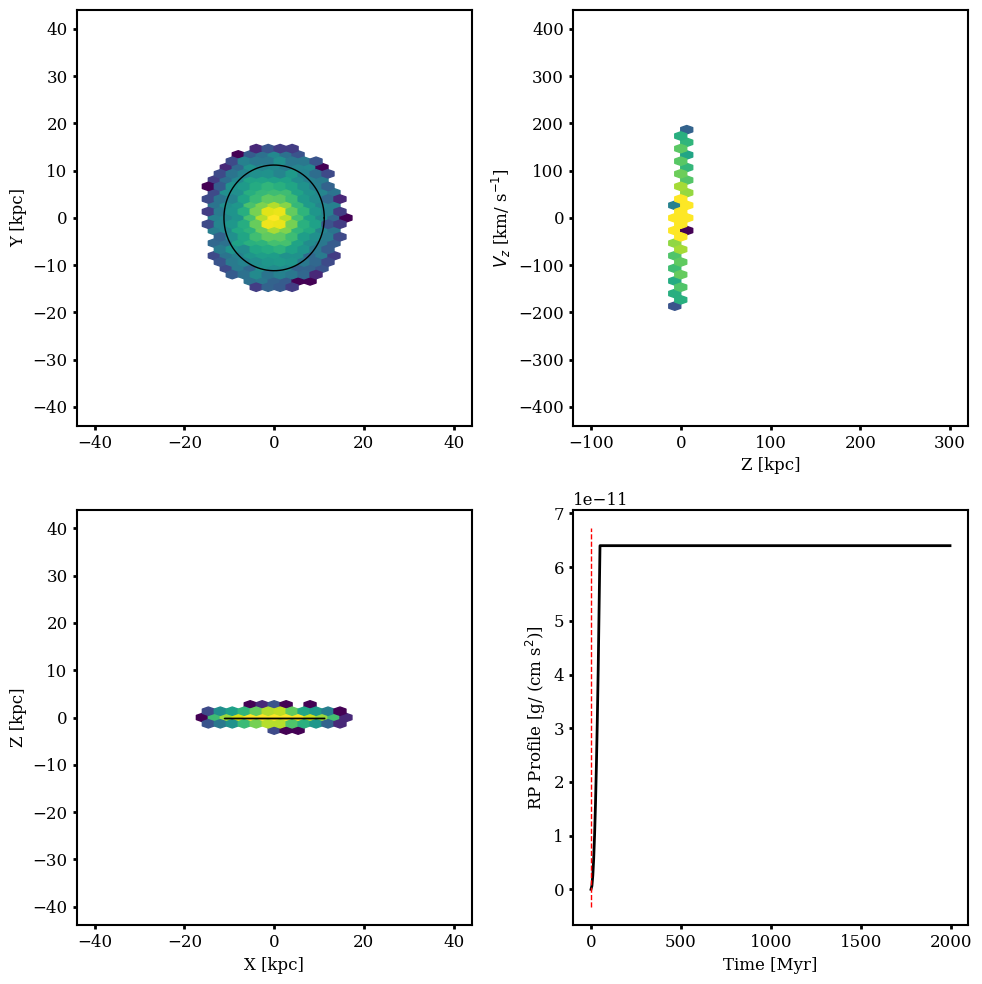

In [92]:
grp.animated_hexbin_plot(orbits, outname=f"figures/animated/RB_dup.gif")

In [94]:
incs = np.linspace(10, 90, 15).astype(int)
# incs = [45]

stripped_fractions = []

for inc in incs:

    rb2006_wind = RB2006_Wind(inc=inc)
    shadow = grp.UniformExponentialZVariableShadow(damping = 0.3, R_disk=rb2006_satellite["gas"].parameters["a"], 
                                                   dynamic=True, z_dropoff=40)
    shadow.init_from_wind(rb2006_wind)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow, rho_icm=1e-26 * u.g/u.cm**3)
    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)


    stripped_fractions.append(grp.stripped(orbits))


  0%|          | 0/399 [00:00<?, ?it/s]/Users/hsouchereau/galarp/galarp/shadows.py:14: RuntimeWarning: divide by zero encountered in divide
  return z / np.tan(phi)
 16%|█▌        | 62/399 [00:01<00:06, 49.18it/s]/Users/hsouchereau/galarp/galarp/rampressure.py:44: RuntimeWarning: overflow encountered in square
  v_perp**2
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:14: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/Users/hsouchereau/galarp/galarp/shadows.py:351: RuntimeWarning: overflow encountered in square
  dist = np.sqrt((x - cent) ** 2 + y**2)
/Users/hsouchereau/gala/gala/integrate/pyintegrators/rk5.py:79: RuntimeWarning: invalid value encountered in multiply
  dw = dw + C[i]*K[i]
100%|██████████| 399/399 [00:07<00:00, 52.82it/s]
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(v

100%|██████████| 399/399 [00:07<00:00, 52.85it/s]


100%|██████████| 399/399 [00:07<00:00, 51.18it/s]


100%|██████████| 399/399 [00:07<00:00, 51.74it/s]


100%|██████████| 399/399 [00:07<00:00, 49.92it/s]


100%|██████████| 399/399 [00:07<00:00, 51.36it/s]


100%|██████████| 399/399 [00:07<00:00, 50.54it/s]


100%|██████████| 399/399 [00:07<00:00, 49.97it/s]


100%|██████████| 399/399 [00:08<00:00, 49.68it/s]


100%|██████████| 399/399 [00:07<00:00, 50.95it/s]


 99%|█████████▉| 397/399 [00:07<00:00, 53.75it/s]/Users/hsouchereau/galarp/galarp/shadows.py:351: RuntimeWarning: invalid value encountered in subtract
  dist = np.sqrt((x - cent) ** 2 + y**2)
100%|██████████| 399/399 [00:07<00:00, 49.96it/s]


100%|██████████| 399/399 [00:08<00:00, 47.35it/s]


100%|██████████| 399/399 [00:08<00:00, 46.51it/s]


100%|██████████| 399/399 [00:08<00:00, 47.60it/s]


100%|██████████| 399/399 [00:08<00:00, 47.60it/s]


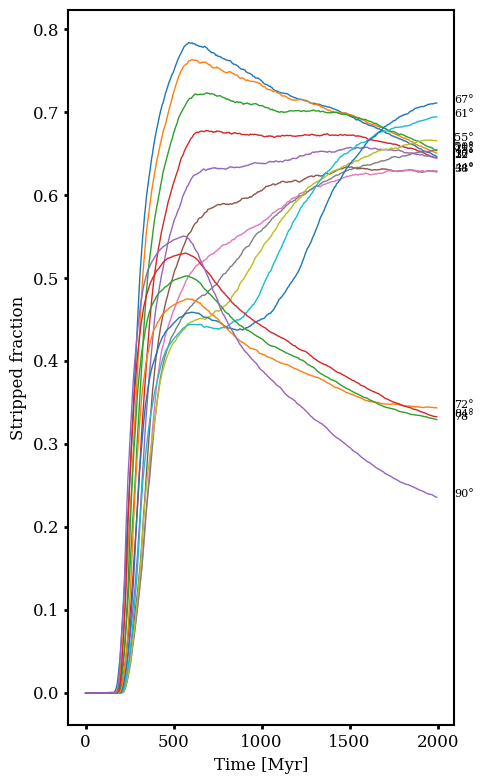

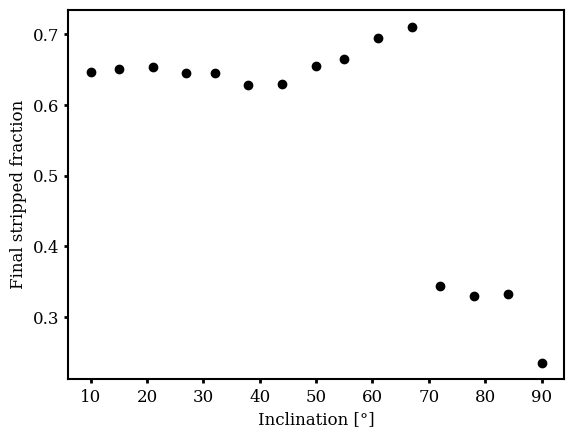

In [98]:
fig = plt.figure(figsize=(5, 8))


for inc, stripped_fraction in zip(incs, stripped_fractions):

    plt.plot(orbits.data.t, stripped_fraction, label=f"{inc}°")
    plt.text(np.max(orbits.data.t).value * 1.05, stripped_fraction[-1], f"{inc}°", fontsize=8)

plt.xlabel("Time [Myr]")
plt.ylabel("Stripped fraction")
#plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(incs, [s[-1] for s in stripped_fractions], c="k")
plt.xlabel("Inclination [°]")
plt.ylabel("Final stripped fraction")
plt.show()

/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_12311/4032714449.py:7: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_12311/4032714449.py:8: RuntimeWarning: overflow encountered in multiply
  vr = (x*vx + y*vy + z*vz) / r
/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_12311/4032714449.py:8: RuntimeWarning: invalid value encountered in divide
  vr = (x*vx + y*vy + z*vz) / r
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5000: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(ix).astype(int)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5001: RuntimeWarning: invalid value enc

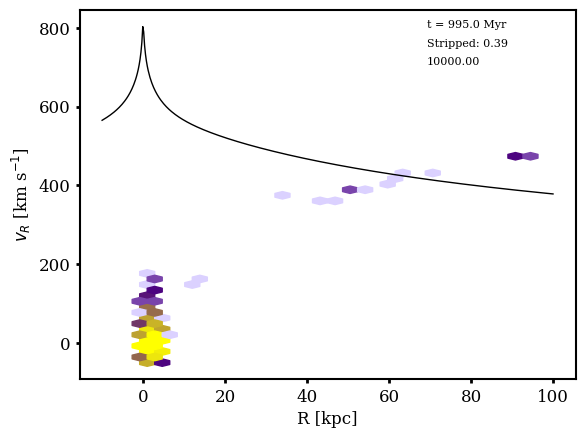

In [150]:
def r_vr(orbits, **kwargs):
    frames = kwargs.get("frames", 200)
    outname = kwargs.get("outname", "r_vr.gif")

    x,y,z, vx, vy, vz = grp.get_orbit_data(orbits.data, transposed=False)

    r = np.sqrt(x**2 + y**2 + z**2)
    vr = (x*vx + y*vy + z*vz) / r

    gridsize = 30
    xextent = (-10, 100)
    yextent = (-50, 800)
    vmin, vmax = 1, 200

    fig, ax = plt.subplots(1, 1)

    hb1 = ax.hexbin(r[0], vr[0], bins="log", cmap=cmap, gridsize=(gridsize, gridsize),
                        extent=[xextent[0], xextent[1], yextent[0], yextent[1]], 
                        vmin=vmin, vmax=vmax, zorder = 5)
    rs = np.linspace(*xextent, 500)

    pot = orbits.metadata["POTENTIAL"]
    v_escs = np.sqrt(2 * np.abs(pot.energy(np.array([np.zeros(len(rs)), np.zeros(len(rs)), rs])))).to(u.km/u.s)
    
    ax.plot(rs, v_escs,
              color="k", lw=1, zorder=10)
    
    def add_labels(ax):
        ax.set_xlabel("R [kpc]")
        ax.set_ylabel(r"$v_R$ [km s$^{-1}$]")

    add_labels(ax)

    def animate(i):
        this_r, this_vr = r[i], vr[i]

        stripped = this_vr > np.sqrt(2 * np.abs(pot.energy(np.array([x[i], y[i], z[i]])))).to(u.km/u.s).value
        ax.cla()

        ax.plot(rs, v_escs, color="k", lw=1, zorder=10)
        
        hb1 = ax.hexbin(this_r, this_vr, bins="log", cmap=cmap, gridsize=(gridsize, gridsize),
                        extent=[xextent[0], xextent[1], yextent[0], yextent[1]], 
                        vmin=vmin, vmax=vmax, zorder = 5)

        xlims, ylims = ax.get_xlim(), ax.get_ylim()
        dx, dy = xlims[1] - xlims[0], ylims[1] - ylims[0]

        ax.text(xlims[1] - 0.2 * dx, ylims[1] - 0.05 * dy, f"t = {orbits.data.t[i]:.1f}", fontsize=8)
        ax.text(xlims[1] - 0.2 * dx, ylims[1] - 0.1 * dy, f"Stripped: {stripped.sum() / len(stripped):.2f}", fontsize=8)

        current_time = orbits.data.t[i].value

        add_labels(ax)
    

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
    ani.save(outname, writer='pillow', fps=24)


r_vr(orbits, outname = "figures/animated/r_vr_RB.gif")